# Preprocessing Script Check

In this notebook we are goint to chack how the proprocessing has been done. Run First the `Apendix A
`


In [3]:

# Data Science Packages
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  matplotlib import pyplot
import seaborn as sns
import warnings
# Seaborn Style
sns.set(style='ticks')
sns.set_style({'font.family': 'Hiragino Maru Gothic Pro'})
sns.set_palette("cool")

# Pandas Style
pd.set_option("display.max_column", 9999)
pd.set_option("display.max_row", 9999)

# Ignore annoying warning 
warnings.filterwarnings('ignore')


from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [4]:
def spark_init():
    """Initialization of the Spark Session

    Returns:
        spark (object): Spark Session.
    """
    spark = SparkSession.builder \
                        .appName("cpe-replacement") \
                        .getOrCreate()
    return spark

spark = spark_init()

# log that main ETL job is starting
print('Preprocessing is up-and-running')
cpetypes = ['W724Ci', 'W724Ci_11AC', 'HA35-11', 'Speedport Plus','ZXDSL931VII','Speedport Plus181','ZXDSL 931VII V4.0']
dataset_version_raw = 'data_w32_g3'
dataset_version_preprocessed = 'Family-all'
root_dir = '../data'
scaling_type = 'standard'

Preprocessing is up-and-running


# 1. Data loading

In [9]:
path_data_preprocessed = root_dir+ "/preprocessed/"+dataset_version_raw+ "/"+dataset_version_preprocessed
df_test = spark.read.parquet(path_data_preprocessed + "/"+str(scaling_type)+"/test.parquet")

In [10]:
df_test.limit(5).toPandas()

,assetid,datum,dslam_distinct_modulation,dslam_no_of_dominant_modulation,dslam_code_of_dominant_modulation,dslam_avg_bitrate_us,dslam_avg_bitrate_ds,dslam_avg_attenuation_ds,dslam_avg_attenuation_us,dslam_avg_power_us,dslam_avg_power_ds,dslam_avg_att_bitrate_us,dslam_avg_att_bitrate_ds,dslam_avg_snr_us,dslam_avg_snr_ds,dslam_no_counts,dslam_avg_bandline_ds,dslam_avg_bandline_us,dslam_sum_cv_us,dslam_count_cv_us,dslam_sum_cv_ds,dslam_count_cv_ds,dslam_sum_es_ds,dslam_count_es_ds,dslam_sum_es_us,dslam_count_es_us,dslam_sum_ses_ds,dslam_count_ses_ds,dslam_sum_ses_us,dslam_count_ses_us,dslam_sum_fec_ds,dslam_count_fec_ds,dslam_sum_fec_us,dslam_count_fec_us,dslam_inits,snmp_no_lossoflink,snmp_no_linkup,snmp_no_dyinggasp,acs_xdslline_dslUptime,acs_xdslline_cpeUptime,acs_xdslline_cpuUsagePercentage,acs_xdslline_freeMemoryKb,acs_xdslline_totalMemoryKb,acs_xdslline_usedMemoryKb,acs_xdslline_natCurrent,acs_xdslline_natMax,acs_xdslline_crc,acs_xdslline_fec,acs_xdslline_hec,acs_xdslline_cellDelin,acs_xdslline_erroredSecs,acs_xdslline_initErrors,acs_xdslline_initTimeOuts,acs_xdslline_severelyErroredSecs,acs_xdslline_linkRetrain,acs_xdslline_lossOfFraming,acs_xdslline_transmitBlocks,acs_xdslline_receiveBlocks,acs_xdslline_downAttenuationDb,acs_xdslline_downCurrRateKbps,acs_xdslline_downMaxRateKbps,acs_xdslline_downNoiseMarginDb,acs_xdslline_downPowerDbm,acs_xdslline_upAttenuationDb,acs_xdslline_upCurrRateKbps,acs_xdslline_upMaxRateKbps,acs_xdslline_upNoiseMarginDb,acs_xdslline_upPowerDbm,acs_xdslline_atuccrc,acs_xdslline_atucfec,acs_xdslline_atuchec,acs_cpe_reset_last_day,acs_xdslline_usedMemoryPercent,acs_xdslline_natCurrentPercent,acs_xdslline_upCurrRateDiff,acs_xdslline_downCurrRateDiff,lb_bytesreceived,lb_bytessent,lb_errorsreceived,lb_errorssent,lb_packetsreceived,lb_packetssent,lb_connecteddevicescount,lb_transmitpower,lb_min_rssi_per_cpe,lb_max_rssi_per_cpe,lb_avg_rssi_per_cpe,lb_errorsreceiveddelta,lb_errorssentdelta,lb_packetsreceiveddelta,lb_packetssentdelta,ub_bytesreceived,ub_bytessent,ub_errorsreceived,ub_errorssent,ub_packetsreceived,ub_packetssent,ub_connecteddevicescount,ub_transmitpower,ub_min_rssi_per_cpe,ub_max_rssi_per_cpe,ub_avg_rssi_per_cpe,ub_errorsreceiveddelta,ub_errorssentdelta,ub_packetsreceiveddelta,ub_packetssentdelta,dslam_platforma_ERICSSONEDA,dslam_platforma_HUAWEISMARTAX,dslam_model_MA5603T,dslam_model_MA5608T,dslam_model_EDAMEDIUMSUBRACK,dslam_model_EDAVDSLSUBRACK,dslam_model_MA5622A,dslam_model_MA5623A,dslam_model_MA5600T,dslam_model_EDASMALLSUBRACK,dslam_card_type_VDPM,dslam_card_type_ADQD,dslam_card_type_BCVSE,dslam_card_type_BCVSB,dslam_card_type_EDN612I,dslam_card_type_VDNF,dslam_card_type_VCPM,dslam_card_type_EDN312XI,dslam_card_type_SDPM,dslam_card_type_ADIF,dslam_card_type_BVCMM,dslam_vdsl_adsl_ADSL,dslam_vdsl_adsl_VDSL,dslam_internet_Y,dslam_internet_N,dslam_iptv_Y,dslam_iptv_N,dslam_voip_Y,dslam_voip_N,cpetype_HA35-11,cpetype_Smart3,cpetype_SpeedportPlus,cpetype_ZXDSL931VII,cpetype_W724Ci,cpetype_SpeedportPlus181,cpetype_ZXDSL931VIIV40,cpetype_FRITZ!Box_6890,cpetype_W724Ci_11AC,ADSLInternet,DTH,ResidentVoIP,ADSLSMART,MultiOffice,IPTV/DTH,PMUP,ADSLMultiOffice,BusinessVoIP,IPTV,IPTVSolo,ADSLBusinessVoIPSolo,Halo3,ADSLPMUP,ADSLCPETest,ResidentVoIPSolo,label_cpe_replacement,label_optical_port,label_reset_not_work,label_sim_slot,label_no_problem,label_healthy,label_reset_itself,label_wifi,label_significant_physical_damage_irreparable,label_lan_port,label_telefon_port,label_blocked,label_device_overheating,label_poor_speed,label_does_not_log_into_acs,label_software,label_dsl_port,label_minor_physical_thermal_damage,label_power_supply,label_internet_not_working
0,105151333,2020-01-26,-0.055041,-0.218840,-1.518451,-0.697086,-0.861315,0.145827,0.591365,0.461944,-1.223839,-0.781667,-0.805578,-0.867638,0.640008,-0.278703,-3.0,-3.0,-0.040684,0.421476,-0.048481,1.810861,-0.053624,2.069981,-0.063015,0.791030,-0.029057,-0.19048,-0.035334,-0.111349,-0.649683,1.582780,-0.263378,-0.502337,-0.083037,-3.000000,-3.000

In [8]:
df.select('assetid').distinct().count()

33832

In [23]:
"""
replacement_datamodule.py

This module defines the data module and dataset class.

.. _Google Python Style Guide:
   http://google.github.io/styleguide/pyguide.html

"""

from omegaconf import OmegaConf

import torch
from torch.utils.data import Dataset

from pyspark.sql import SparkSession
import pyspark.sql.functions as F


class ReplacementDataset(Dataset):
    """
    Replacement dataset.
    """
    def __init__(self,
                 data_dir,
                 features_dim,
                 series_dim,
                 name_labels,
                 weights_labels,
                 features_numerical,
                 features_categorical):
        """Init paramaters for dataset building.

        Args:
            data_dir (str): Path to data.
            features_dim (int): Number of Features.
            series_dim (int): Number of elements in the time series.
            name_labels (list[str]): List of label names.
            weights_labels (list[int]: List of weights per label name)

        """
        super(ReplacementDataset, self).__init__()

        self.data_dir = data_dir
        self.features_dim = features_dim
        self.series_dim = series_dim
        self.name_labels = list(name_labels)
        self.weights_labels = list(weights_labels)
        self.features_numerical = list(features_numerical)
        self.features_categorical = list(features_categorical)

        self.data = self.read_data()
        self.asset_ids = self.get_asset_ids()

    def spark_init(self):
        """Initialization of the Spark Session

        Returns:
            spark (object): Spark Session.
        """
        spark = SparkSession.builder \
                            .appName("cpe-replacement") \
                            .config("spark.driver.memory", "2g") \
                            .getOrCreate()
        return spark

    def read_data(self):
        """Load Spark dataframe and transformed to pandas
        dataframe.

        Returns:
            dataframe: data.
        """
        spark = self.spark_init()
        df = spark.read.parquet(self.data_dir)
        df = df.filter(F.col('label_healthy')==0)
        data = df.toPandas()
        return data

    def get_asset_ids(self):
        """Get unique asset ids.

        Returns:
            list: asset ids.
        """
        return self.data.assetid.unique()

    def __len__(self):
        """Dataset length.
        Returns:
            int: Dataset length.
        """
        return len(self.asset_ids)

    def __getitem__(self, idx: int):
        """Get item.
        Args:
            idx (int): Index.
        Returns:
            {
                str: User ID,
                list: [batch, num_click_docs, seq_len],
                list: [batch, num_candidate_docs, seq_len],
                bool: candidate docs label (0 or 1)
            }
        """
        # Filter by assetid
        item = self.data.loc[self.data.assetid == self.asset_ids[idx]].copy()

        # Sort by date
        item = item.sort_values('datum')
        seq_len = item.shape[0]
        seq_id = [i/seq_len for i in range(seq_len)]
        item['seq_id'] = seq_id

        # Labels
        labels = item[self.name_labels].values[0]
        labels = torch.tensor(labels).type(torch.FloatTensor)

        # Input
        input = item[['seq_id']+ self.features_numerical + self.features_categorical].values
        input = torch.tensor(input).type(torch.FloatTensor)

        # Padder days
        padder_sequence = torch.zeros(self.series_dim - input.shape[0],
                                      input.shape[1])
        input = torch.cat([padder_sequence, input], dim=0)

        # Padder features
        padder_features = torch.zeros(self.series_dim,
                                      self.features_dim - input.shape[1])
        input = torch.cat([padder_features, input], dim=1)

        # Weights
        weights = torch.tensor(self.weights_labels).type(torch.FloatTensor)

        return input, labels, weights



In [24]:
"""
datamodule.py

This module defines the data module and dataset class.

.. _Google Python Style Guide:
   http://google.github.io/styleguide/pyguide.html

"""


import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

from pytorch_lightning import LightningDataModule
import pandas as pd



class ReplacementDataModule(LightningDataModule):
    """Data Module for CPE Replacement.
    """

    def __init__(self,
                 data_dir: str = "data/preprocessed",
                 train_val_split: float = 0.9,
                 batch_size: int = 32,
                 num_workers: int = 0,
                 pin_memory: bool = False,
                 features_dim: int = 184,
                 series_dim: int = 32,
                 name_labels: list = ["label_cpe_replacement"],
                 weights_labels: list = [1],
                 features_numerical: list = [],
                 features_categorical: list = [], 
                 **kwargs,):
        """Init data module.

        The deafult parametera can be set using the file config.datamodule.cpe-replacement.yaml

        Args:
            data_dir (str): Preprocessed data directory.
            train_val_split (float): Dataset share assing for training.
            batch_size (int): Batch size,
            num_workers (int): Number of parallel workers in a GPU env.
            pin_memory (bool): Pin memory enable for GOU env,
            series_dim (int): Time series length.
            features_dim (int): Number of features.
            name_labels (list[str]): Label names used in training.

        """
        super().__init__()

        self.data_dir = data_dir
        self.train_val_split = train_val_split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.features_dim = features_dim
        self.series_dim = series_dim
        self.name_labels = name_labels
        self.weights_labels = weights_labels
        self.features_numerical = features_numerical
        self.features_categorical = features_categorical

    def setup(self, stage=None):
        # Setup function is key when handling dataloaders inside the class since
        # this function is triggered when training or testing the model by passing the
        # right datasets (training, validation and testing)
        if not os.path.exists(self.data_dir + "/torch"):
            os.makedirs(self.data_dir + '/torch')
            train_dataset = ReplacementDataset(self.data_dir + "/train.parquet",
                                               self.features_dim,
                                               self.series_dim,
                                               self.name_labels,
                                               self.weights_labels,
                                               self.features_numerical,
                                               self.features_categorical)
            torch.save(train_dataset, self.data_dir + '/torch/train.pt')

            test_dataset = ReplacementDataset(self.data_dir + "/test.parquet",
                                              self.features_dim,
                                              self.series_dim,
                                              self.name_labels,
                                              self.weights_labels,
                                              self.features_numerical,
                                              self.features_categorical)
            torch.save(test_dataset, self.data_dir + '/torch/test.pt')

        if stage == 'fit' or stage is None:
            dataset = torch.load(self.data_dir + '/torch/train.pt')
            ds_size = dataset.__len__()
            train_size = int(self.train_val_split * ds_size)
            val_size = ds_size - train_size
            split = [train_size, val_size]
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(dataset, split)

        if stage == 'test' or stage is None:
            self.test_dataset = torch.load(self.data_dir + '/torch/test.pt')

        self.train_sampler = self.get_sampler(self.train_dataset)



    def train_dataloader(self):
        # Called when training the model, for balance sampler add in args
        # sampler=self.train_sampler, otherwise shuffle=True
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          sampler=self.train_sampler,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Called when evaluating the model (for each "n" steps or "n" epochs)
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Called when testing the model by calling: Trainer.test()
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


In [31]:
import torch


class TransformerEncoder(torch.nn.Module):
    def __init__(self, hparams: dict):
        super().__init__()
        self.multihead_attention = torch.nn.MultiheadAttention(hparams['embed_dim'],
                                                               hparams['num_heads'],
                                                               hparams['dropout'],
                                                               batch_first=True)
        
        self.feedforward = PositionwiseFeedForward(hparams['embed_dim'], 
                                                   hparams['feedforward_dim'],
                                                   hparams['dropout'])

        self.dropout= torch.nn.Dropout(hparams['dropout'])
        self.layernorm_attention = torch.nn.LayerNorm(hparams['embed_dim'])
        self.layernorm_feedforward = torch.nn.LayerNorm(hparams['embed_dim'])
    
    def forward(self, x):
        # Multi-Head Attention.
        attention_out, _ = self.multihead_attention(x, x, x)
        # Add & Norm
        x = self.layernorm_attention(x + self.dropout(attention_out))
        # Position wise FeedForward
        feedforward_out = self.feedforward(x)
        # Add & Norm
        x = self.layernorm_feedforward(x + self.dropout(feedforward_out))
        return x


class PositionwiseFeedForward(torch.nn.Module):
    "Implements FFN equation."
    def __init__(self, embed_dim, feedforward_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear_in = torch.nn.Linear(embed_dim, feedforward_dim)
        self.linear_out = torch.nn.Linear(feedforward_dim, embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        return self.linear_out(self.dropout(torch.relu(self.linear_in(x))))

In [32]:
import torch
import numpy as np
class SwapNoiseMasker(object):
    def __init__(self, hparams: dict):
        self.num_numerical = hparams['num_numerical']
        self.num_category = hparams['num_category']
        self.swap_category = hparams['swap_category']
        self.swap_numerical = hparams['swap_numerical']
        self.probas = torch.tensor(self.num_numerical * [self.swap_numerical] + self.num_category * [self.swap_category])
        

    def apply(self, input):
        should_swap = torch.bernoulli(self.probas * torch.ones(input.shape))
        input_noise = torch.cat([input[torch.randint(input.shape[0],(1,1)).item()][torch.randperm(input.shape[1])].unsqueeze(0) for i in range(input.shape[0])])
        corrupted_input = torch.where(should_swap == 1, input_noise, input)
        mask = (corrupted_input != input).float()
        return corrupted_input, mask

In [34]:
"""src.models.transformer_autoencoder.py

This module defines the tranformer autoencoder.

.. _Google Python Style Guide:
   http://google.github.io/styleguide/pyguide.html

"""

__author__ = "Luis Felipe Villa Arenas"
__copyright__ = "Deutsche Telekom"


import torch
import torch.nn as nn
import pytorch_lightning as pl



class TransformerAutoEncoder(pl.LightningModule):
    """
    Transformer Autoencoder.
    """
    def __init__(self,
                 init_lr = 0.001,
                 lr_decay = 0.03, 
                 num_category = 125, 
                 num_numerical = 75, 
                 seq_len = 32, 
                 embed_dim = 200, 
                 num_heads = 2, 
                 dropout = .1, 
                 feedforward_dim = 400, 
                 emphasis = .75,
                 numerical_weight_loss = 0.8,
                 categorical_weight_loss = 0.2,
                 mask_weight_loss = 2,
                 swap_category = 0.5,
                 swap_numerical = 0.2,
                 **kwargs):
        """Init Autoencoder parameters.

        The deafult parametera can be set using the file config.model.conv-autoenc.yaml

        Args:
            init_lr (float): Initial learning rate.
            lr_decay (float): Learning rate decay used by the scheduler
            num_category (int): Number of categorical features.
            num_numerical (init): Number of numerical features.
            seq_len (int): Sequence length.
            embed_dim (init): Embedding size.
            num_heads (init): Number of heads.
            dropout (float): Dropout probability.
            feedforward_dim (int): Dimension position-wise feedforward net.
            emphasis (float): Masked position emphasis weight.
            numerical_weight_loss (float): Weights for numerical loss.
            categorical_weight_loss (float): Weights for categorical loss.
            mask_weight_loss (float): Weights for mask loss.
            swap_category (float): Noiseswap probability for categorical features.
            swap_numerical (float): Noiseswap probability for numerical features.
        """
        super(TransformerAutoEncoder, self).__init__()

        self.save_hyperparameters()
        
        # Init Linear Layers
        self.linear_mask_predictor = torch.nn.Linear(in_features=self.hparams.embed_dim * self.hparams.seq_len, 
                                              out_features=self.hparams.embed_dim * self.hparams.seq_len)
        
        self.linear_reconstructor = torch.nn.Linear(in_features=2 * self.hparams.embed_dim * self.hparams.seq_len, 
                                             out_features=self.hparams.embed_dim * self.hparams.seq_len)

        # Init Swap Noiser 
        self.noise_maker = SwapNoiseMasker(self.hparams)

        # Init Tranformer layers
        self.encoder_low = TransformerEncoder(self.hparams)                            
        self.encoder_medium = TransformerEncoder(self.hparams)
        self.encoder_high = TransformerEncoder(self.hparams)

        # loss function
        self.criterion_mse = torch.nn.functional.mse_loss
        self.criterion_bce_logits = torch.nn.functional.binary_cross_entropy_with_logits

    def forward(self, x):
        first_features = self.encoder_low(x)
        intermin_features = self.encoder_medium(first_features)
        last_features = self.encoder_high(intermin_features)
        return (first_features, intermin_features, last_features)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.hparams.init_lr
                                      )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 
                                                           gamma=self.hparams.lr_decay
                                                           )
        return [optimizer], [scheduler]

    def step(self, batch):
        input, labels, weights = batch

        # Corrupting Input
        input_corrputed, mask = self.noise_maker.apply(input)
    
        # Output features from transformer layers
        (_, _, last_features) = self.forward(input_corrputed)
        
        # Unroll features
        last_features_unroll = self.sequence_unroll(last_features)
        
        # Prediction mask and reconstruction
        predicted_mask_unroll = self.linear_mask_predictor(last_features_unroll)
        reconstruction_unroll = self.linear_reconstructor(torch.cat([last_features_unroll, predicted_mask_unroll], dim=1))

        # Roll mask prediction and reconstruction
        reconstruction = self.sequence_roll(reconstruction_unroll)
        predicted_mask = self.sequence_roll(predicted_mask_unroll)

        # Losses Reconstruction and mask
        numerical_loss, categorical_loss = self.reconstruction_loss(input, reconstruction, mask)                                 
        mask_loss = self.mask_loss(mask, predicted_mask)
       
        return numerical_loss, categorical_loss, mask_loss
    
    def reconstruction_loss(self, input, reconstruction, mask):
        input_recover_numerical, input_recover_categorical = self.split(reconstruction)
        input_numerical, input_categorical = self.split(input)
        mask_emphasis = mask * self.hparams.emphasis + (1 - mask) * (1 - self.hparams.emphasis)
        weights_numerical, weights_categorical = self.split(mask_emphasis)
        categorical_loss = torch.mul(weights_categorical, self.criterion_bce_logits(input_recover_categorical,
                                                                                    input_categorical,
                                                                                    reduction='none'))
        numerical_loss = torch.mul(weights_numerical, self.criterion_mse(input_recover_numerical,
                                                                        input_numerical,
                                                                        reduction='none'))
        return numerical_loss.mean(), categorical_loss.mean()
    
    def apply_weights(self, numerical_loss, categorical_loss, mask_loss):
        numerical_loss = self.hparams.numerical_weight_loss * numerical_loss
        categorical_loss = self.hparams.categorical_weight_loss * categorical_loss
        mask_loss = self.hparams.mask_weight_loss * mask_loss
        return numerical_loss, categorical_loss, mask_loss

    def mask_loss(self, mask, predicted_mask):
        mask_loss = self.criterion_bce_logits(predicted_mask,
                                              mask,
                                              reduction='mean')
        return mask_loss

    def sequence_roll(self, x):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, self.hparams.seq_len, self.hparams.embed_dim))
        return x

    def sequence_unroll(self, x):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, -1))
        return x

    def split(self, x):
        return torch.split(x, [self.hparams.num_numerical, self.hparams.num_category], dim=2)

    def feature(self, x):
        attn_outs = self.forward(x)
        return torch.cat([self.sequence_unroll(x) for x in attn_outs], dim=1)

    def training_step(self, batch, batch_idx):
        numerical_loss, categorical_loss, mask_loss = self.step(batch)
        numerical_loss_weight, categorical_loss_weight, mask_loss_weight = self.apply_weights(numerical_loss,
                                                                                              categorical_loss,
                                                                                              mask_loss)
        loss = numerical_loss_weight + categorical_loss_weight + mask_loss_weight
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train/numerical_loss", numerical_loss)
        self.log("train/categorical_loss", categorical_loss)
        self.log("train/mask_loss", mask_loss)
        return loss

    def validation_step(self, batch, batch_idx):
        numerical_loss, categorical_loss, mask_loss = self.step(batch)
        numerical_loss_weight, categorical_loss_weight, mask_loss_weight = self.apply_weights(numerical_loss,
                                                                                              categorical_loss,
                                                                                              mask_loss)                                                                                    
        loss = numerical_loss_weight + categorical_loss_weight + mask_loss_weight
        return {"loss": loss, "numerical_loss":numerical_loss, "categorical_loss":categorical_loss, "mask_loss":mask_loss}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.tensor([x["loss"] for x in outputs]).mean()
        avg_val_numerical_loss = torch.tensor([x["numerical_loss"] for x in outputs]).mean()
        avg_val_categorical_loss = torch.tensor([x["categorical_loss"] for x in outputs]).mean()
        avg_val_mask_loss = torch.tensor([x["mask_loss"] for x in outputs]).mean()
        self.log("val/loss", avg_val_loss)
        self.log("val/numerical_loss", avg_val_numerical_loss)
        self.log("val/categorical_loss", avg_val_categorical_loss)
        self.log("val/mask_loss", avg_val_mask_loss)

    def test_step(self, batch, batch_idx):
        numerical_loss, categorical_loss, mask_loss = self.step(batch)
        numerical_loss_weight, categorical_loss_weight, mask_loss_weight = self.apply_weights(numerical_loss,
                                                                                              categorical_loss,
                                                                                              mask_loss)
        loss = numerical_loss_weight + categorical_loss_weight + mask_loss_weight
        return {"loss": loss, "numerical_loss":numerical_loss, "categorical_loss":categorical_loss, "mask_loss":mask_loss}

    def test_epoch_end(self, outputs):
        avg_test_loss = torch.tensor([x["loss"] for x in outputs]).mean()
        avg_test_numerical_loss = torch.tensor([x["numerical_loss"] for x in outputs]).mean()
        avg_test_categorical_loss = torch.tensor([x["categorical_loss"] for x in outputs]).mean()
        avg_test_mask_loss = torch.tensor([x["mask_loss"] for x in outputs]).mean()
        self.log("test/loss", avg_test_loss)
        self.log("test/numerical_loss", avg_test_numerical_loss)
        self.log("test/categorical_loss", avg_test_categorical_loss)
        self.log("test/mask_loss", avg_test_mask_loss)



"""
src.models.transformer_classifier.py

This module uses a pretrain encoder combined with MLP to classify abnormalities.

.. _Google Python Style Guide:
   http://google.github.io/styleguide/pyguide.html

"""

__author__ = "Luis Felipe Villa Arenas"
__copyright__ = "Deutsche Telekom"


import pytorch_lightning as pl

import torch
import torch.nn as nn
import torchmetrics



class ReplacementTransformerClassifier(pl.LightningModule):
    """
    Convolutional Classifier.
    """
    def __init__(self,
                 init_lr = 0.001,
                 lr_decay = 0.03, 
                 num_category = 54, 
                 num_numerical = 106, 
                 seq_len = 32, 
                 embed_dim = 160, 
                 num_heads = 4, 
                 dropout = .1, 
                 feedforward_dim = 512, 
                 emphasis = .75,
                 numerical_weight_loss = 0.8,
                 categorical_weight_loss = 0.2,                 
                 mask_weight_loss = 2,
                 swap_category = 0.5,
                 swap_numerical = 0.2,
                 inter_dim = 250,
                 output_dim = 2,
                 freeze_encoder =  True,
                 name_labels_logger = ['label_no_problem','label_cpe_replacement'],
                 checkpoint =  '/Users/luisfelipevillaarenas/Documents/T-con/Projects/predictive_care/cpe-replacement/logs/runs/transformer-autoencoder/2021-08-16/18-55-32/checkpoints/epoch=73.ckpt',
                 **kwargs):
        """Init Convolutional classifier parameters.

        The deafult parameters can be set using the file config.model.conv-classifier.yaml

        Args:
            init_lr (float): Initial learning rate.
            lr_decay (float): Learning rate decay used by the scheduler
            num_category (int): Number of categorical features.
            num_numerical (init): Number of numerical features.
            seq_len (int): Sequence length.
            embed_dim (init): Embedding size.
            num_heads (init): Number of heads.
            dropout (float): Dropout probability.
            feedforward_dim (int): Dimension position-wise feedforward net.
            emphasis (float): Masked position emphasis weight.
            numerical_weight_loss (float): Weights for numerical loss.
            categorical_weight_loss (float): Weights for categorical loss.
            mask_weight_loss (float): Weights for mask loss.
            swap_category (float): Noiseswap probability for categorical features.
            swap_numerical (float): Noiseswap probability for numerical features.
            output_dim (int): Output dimmesion
            freeze_encoder (boolean): Flag to freeze teh weights of pretrain model.
            name_labels_logger (list[str]): label names used in logger eg. WandB.
            checkpoint (dir): Pretrain model's Checkpoint directory.
        """
        super(ReplacementTransformerClassifier, self).__init__()

        # Hyperparameters
        self.save_hyperparameters()

        # Init the pretrained LightningModule
        self.autoencoder = TransformerAutoEncoder(init_lr=self.hparams.init_lr,
                                                  lr_decay=self.hparams.lr_decay, 
                                                  num_category=self.hparams.num_category, 
                                                  num_numerical=self.hparams.num_numerical, 
                                                  seq_len=self.hparams.seq_len, 
                                                  embed_dim=self.hparams.embed_dim, 
                                                  num_heads=self.hparams.num_heads, 
                                                  dropout=self.hparams.dropout, 
                                                  feedforward_dim=self.hparams.feedforward_dim, 
                                                  emphasis=self.hparams.emphasis,
                                                  numerical_weight_loss=self.hparams.numerical_weight_loss,
                                                  categorical_weight_loss=self.hparams.categorical_weight_loss,
                                                  mask_weight_loss=self.hparams.mask_weight_loss,
                                                  swap_category=self.hparams.swap_category,
                                                  swap_numerical=self.hparams.swap_numerical)

        self.autoencoder.load_from_checkpoint(self.hparams.checkpoint)

        # Freeze Pretrain encoder
        if self.hparams.freeze_encoder:
            self.autoencoder.freeze()

        # Init Layers
        self.dropout = nn.Dropout(p=self.hparams.dropout)

        self.input_linear = nn.Linear(2* self.hparams.embed_dim * self.hparams.seq_len,
                                      self.hparams.inter_dim)

        self.output_linear = nn.Linear(self.hparams.inter_dim,
                                       self.hparams.output_dim)

        # Criterion
        self.criterion = nn.BCELoss()

    def forward(self, x):
        # Feature extractor
        first_features, intermin_features, last_features = self.autoencoder(x)
        # Unroll input and features
        input_unroll = self.sequence_unroll(x)
        last_features_unroll = self.sequence_unroll(last_features)
        # Enriching Input
        input_expanded = torch.cat([last_features_unroll, input_unroll], dim=1)
        # Classifier
        x = torch.relu((self.dropout(self.input_linear(input_expanded))))
        x = torch.sigmoid((self.output_linear(x)))
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.hparams.init_lr
                                      )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 
                                                           gamma=self.hparams.lr_decay
                                                           )
        return [optimizer], [scheduler]

    def sequence_unroll(self, x):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, -1))
        return x

    def metrics_logger_custom(self, predictions, targets, prefix):
        prefix = prefix + '/'
        outputs = dict()
        for idx, l in enumerate(self.hparams.name_labels_logger):
            preds = predictions[:, idx]
            target = targets[:, idx].int()
            outputs[prefix + l + '/accuracy'] = torchmetrics.functional.accuracy(preds, target)
            outputs[prefix + l + '/precision'] = torchmetrics.functional.precision(preds, target)
            outputs[prefix + l + '/recall'] = torchmetrics.functional.recall(preds, target)
            outputs[prefix + l + '/f1'] = torchmetrics.functional.f1(preds, target)
        return outputs

    def training_step(self, batch, batch_idx):
        input, labels, weights = batch
        predictions = self(input)
        self.criterion.weight = weights
        loss = self.criterion(predictions, labels)
        outputs = self.metrics_logger_custom(predictions, labels, 'train')
        self.log('train/loss_step', loss)
        return {'loss': loss, 'metrics': outputs}

    def training_epoch_end(self, outputs):
        for _, metric in enumerate(outputs[0]['metrics'].keys()):
            self.log(metric, torch.tensor([x['metrics'][metric] for x in outputs]).mean())

    def validation_step(self, batch, batch_idx):
        input, labels, weights = batch
        predictions = self(input)
        self.criterion.weight = weights
        loss = self.criterion(predictions, labels)
        outputs = self.metrics_logger_custom(predictions, labels, 'val')
        outputs['val/loss'] = loss
        return outputs

    def validation_epoch_end(self, outputs):
        for _, metric in enumerate(outputs[0].keys()):
            self.log(metric, torch.tensor([x[metric] for x in outputs]).mean())

    def test_step(self, batch, batch_idx):
        input, labels, weights = batch
        predictions = self(input)
        outputs = self.metrics_logger_custom(predictions, labels, 'test')
        return outputs

    def test_epoch_end(self, outputs):
        for _, metric in enumerate(outputs[0].keys()):
            self.log(metric, torch.tensor([x[metric] for x in outputs]).mean())


In [27]:
conf_datamodule ={'data_dir': '/Users/luisfelipevillaarenas/Documents/T-con/Projects/predictive_care/cpe-replacement/data/preprocessed/data_w32_g3/Family-All/standard',
                    'batch_size': 32,
                    'train_val_split': 0.9,
                    'num_workers': 0,
                    'pin_memory': False,
                    'features_dim': 160,
                    'series_dim': 32,
                    'name_labels':    ['label_no_problem','label_cpe_replacement'],
                    'weights_labels': [1, 2],
                    'features_numerical': ['dslam_distinct_modulation', 'dslam_no_of_dominant_modulation', 'dslam_code_of_dominant_modulation', 'dslam_avg_bitrate_us', 'dslam_avg_bitrate_ds', 'dslam_avg_attenuation_ds', 'dslam_avg_attenuation_us', 'dslam_avg_power_us', 'dslam_avg_power_ds', 'dslam_avg_att_bitrate_us', 'dslam_avg_att_bitrate_ds', 'dslam_avg_snr_us', 'dslam_avg_snr_ds', 'dslam_no_counts', 'dslam_avg_bandline_ds', 'dslam_avg_bandline_us', 'dslam_sum_cv_us', 'dslam_count_cv_us', 'dslam_sum_cv_ds', 'dslam_count_cv_ds', 'dslam_sum_es_ds', 'dslam_count_es_ds', 'dslam_sum_es_us', 'dslam_count_es_us', 'dslam_sum_ses_ds', 'dslam_count_ses_ds', 'dslam_sum_ses_us', 'dslam_count_ses_us', 'dslam_sum_fec_ds', 'dslam_count_fec_ds', 'dslam_sum_fec_us', 'dslam_count_fec_us', 'dslam_inits', 'snmp_no_lossoflink', 'snmp_no_linkup', 'snmp_no_dyinggasp', 'acs_xdslline_dslUptime', 'acs_xdslline_cpeUptime', 'acs_xdslline_cpuUsagePercentage', 'acs_xdslline_freeMemoryKb', 'acs_xdslline_totalMemoryKb', 'acs_xdslline_usedMemoryKb', 'acs_xdslline_natCurrent', 'acs_xdslline_natMax', 'acs_xdslline_crc', 'acs_xdslline_fec', 'acs_xdslline_hec', 'acs_xdslline_cellDelin', 'acs_xdslline_erroredSecs', 'acs_xdslline_initErrors', 'acs_xdslline_initTimeOuts', 'acs_xdslline_severelyErroredSecs', 'acs_xdslline_linkRetrain', 'acs_xdslline_lossOfFraming', 'acs_xdslline_transmitBlocks', 'acs_xdslline_receiveBlocks', 'acs_xdslline_downAttenuationDb', 'acs_xdslline_downCurrRateKbps', 'acs_xdslline_downMaxRateKbps', 'acs_xdslline_downNoiseMarginDb', 'acs_xdslline_downPowerDbm', 'acs_xdslline_upAttenuationDb', 'acs_xdslline_upCurrRateKbps', 'acs_xdslline_upMaxRateKbps', 'acs_xdslline_upNoiseMarginDb', 'acs_xdslline_upPowerDbm', 'acs_xdslline_atuccrc', 'acs_xdslline_atucfec', 'acs_xdslline_atuchec', 'acs_cpe_reset_last_day', 'acs_xdslline_usedMemoryPercent', 'acs_xdslline_natCurrentPercent', 'acs_xdslline_upCurrRateDiff', 'acs_xdslline_downCurrRateDiff', 'lb_bytesreceived', 'lb_bytessent', 'lb_errorsreceived', 'lb_errorssent', 'lb_packetsreceived', 'lb_packetssent', 'lb_connecteddevicescount', 'lb_transmitpower', 'lb_min_rssi_per_cpe', 'lb_max_rssi_per_cpe', 'lb_avg_rssi_per_cpe', 'lb_errorsreceiveddelta', 'lb_errorssentdelta', 'lb_packetsreceiveddelta', 'lb_packetssentdelta', 'ub_bytesreceived', 'ub_bytessent', 'ub_errorsreceived', 'ub_errorssent', 'ub_packetsreceived', 'ub_packetssent', 'ub_connecteddevicescount', 'ub_transmitpower', 'ub_min_rssi_per_cpe', 'ub_max_rssi_per_cpe', 'ub_avg_rssi_per_cpe', 'ub_errorsreceiveddelta', 'ub_errorssentdelta', 'ub_packetsreceiveddelta', 'ub_packetssentdelta'],

                    'features_categorical': ['dslam_platforma_ERICSSONEDA', 'dslam_platforma_HUAWEISMARTAX', 'dslam_model_MA5603T', 'dslam_model_MA5608T', 'dslam_model_EDAMEDIUMSUBRACK', 'dslam_model_EDAVDSLSUBRACK', 'dslam_model_MA5622A', 'dslam_model_MA5623A', 'dslam_model_MA5600T', 'dslam_model_EDASMALLSUBRACK', 'dslam_card_type_VDPM', 'dslam_card_type_ADQD', 'dslam_card_type_BCVSE', 'dslam_card_type_BCVSB', 'dslam_card_type_EDN612I', 'dslam_card_type_VDNF', 'dslam_card_type_VCPM', 'dslam_card_type_EDN312XI', 'dslam_card_type_SDPM', 'dslam_card_type_ADIF', 'dslam_card_type_BVCMM', 'dslam_vdsl_adsl_ADSL', 'dslam_vdsl_adsl_VDSL', 'dslam_internet_Y', 'dslam_internet_N', 'dslam_iptv_Y', 'dslam_iptv_N', 'dslam_voip_Y', 'dslam_voip_N', 'cpetype_HA35-11', 'cpetype_Smart3', 'cpetype_SpeedportPlus', 'cpetype_ZXDSL931VII', 'cpetype_W724Ci', 'cpetype_SpeedportPlus181', 'cpetype_ZXDSL931VIIV40', 'cpetype_FRITZ!Box_6890', 'cpetype_W724Ci_11AC', 'ADSLInternet', 'DTH', 'ResidentVoIP', 'ADSLSMART', 'MultiOffice', 'IPTV/DTH', 'PMUP', 'ADSLMultiOffice', 'BusinessVoIP', 'IPTV', 'IPTVSolo', 'ADSLBusinessVoIPSolo', 'Halo3', 'ADSLPMUP', 'ADSLCPETest', 'ResidentVoIPSolo']
                 }

In [29]:
datamodule = ReplacementDataModule(data_dir = conf_datamodule['data_dir'],
                     train_val_split= 0.9,
                     batch_size= 32,
                     num_workers = 0,
                     pin_memory= False,
                     features_dim = conf_datamodule['features_dim'],
                     series_dim = 32,
                     name_labels = conf_datamodule['name_labels'],
                     weights_labels = conf_datamodule['weights_labels'],
                     features_numerical = conf_datamodule['features_numerical'],
                     features_categorical = conf_datamodule['features_categorical'], )

In [35]:
model = ReplacementTransformerClassifier()

In [36]:
model.load_from_checkpoint('/Users/luisfelipevillaarenas/Documents/T-con/Projects/predictive_care/cpe-replacement/logs/runs/transformer-classifier/2021-08-18/07-13-41/checkpoints/epoch=08.ckpt')

RuntimeError: Error(s) in loading state_dict for ReplacementTransformerClassifier:
	Unexpected key(s) in state_dict: "criterion.weight". 

# 2. Config Preprocessing

In [9]:
config_preprocess = {
        'features_drop': 
                [ 'CPE_SERIAL_NUMBER','TICKET_ID','ASSET_ID',
                'TICKET_TENTATIVE_ROOT_CAUSE','START_DATE_TICKET',
                'DATE_SCAN_START','DATE_SCAN_END','CPE_ISSUE',
                'WINDOW_END','WINDOW_START', 'dslam_port_inst_id',
                'dslam_rg_port_inst_id','dslam_prim_izvod_inst_id',
                'dslam_date_inserted','dslam_bandwidth','dslam_vendor',
                'dslam_regija', 'acs_@type','acs_crm_accessNetwork', 
                'acs_crm_dslamFrame', 'acs_crm_dslamSlot','acs_xdslline_additionalSoftwareVersion', 
                'acs_xdslline_anexType','acs_xdslline_linkEncapsulationType',
                'acs_xdslline_pppoEUsername','acs_createdmsec','acs_xdslline_lossOfPower',
                'acs_xdslline_manufacturer', 'acs_xdslline_manufacturerOui', 'acs_xdslline_softwareVersion'],

        'features_uptime': 
                ['acs_xdslline_crc','acs_xdslline_fec','acs_xdslline_hec',
                'acs_xdslline_erroredSecs','acs_xdslline_cellDelin',
                'acs_xdslline_erroredSecs', 'acs_xdslline_initErrors',
                'acs_xdslline_initTimeOuts','acs_xdslline_severelyErroredSecs',
                'acs_xdslline_linkRetrain','acs_xdslline_lossOfFraming',
                'acs_xdslline_transmitBlocks','acs_xdslline_receiveBlocks', 
                'acs_xdslline_atuccrc','acs_xdslline_atucfec','acs_xdslline_atuchec',
                'lb_bytesreceived', 'lb_bytessent', 'lb_errorsreceived', 'lb_errorssent', 'lb_packetsreceived','lb_packetssent',
                'ub_bytesreceived', 'ub_bytessent', 'ub_errorsreceived', 'ub_errorssent', 'ub_packetsreceived','ub_packetssent',],

        'features_categorical': 
                ['dslam_platforma', 'dslam_model', 'dslam_card_type','dslam_vdsl_adsl',                                             
                'dslam_internet', 'dslam_iptv', 'dslam_voip',                                               
                'acs_crm_serviceName', 'cpetype'],
    
        'features_numerical': ['dslam_distinct_modulation',
                 'dslam_no_of_dominant_modulation',
                 'dslam_code_of_dominant_modulation',
                 'dslam_avg_bitrate_us',
                 'dslam_avg_bitrate_ds',
                 'dslam_avg_attenuation_ds',
                 'dslam_avg_attenuation_us',
                 'dslam_avg_power_us',
                 'dslam_avg_power_ds',
                 'dslam_avg_att_bitrate_us',
                 'dslam_avg_att_bitrate_ds',
                 'dslam_avg_snr_us',
                 'dslam_avg_snr_ds',
                 'dslam_no_counts',
                 'dslam_avg_bandline_ds',
                 'dslam_avg_bandline_us',
                 'dslam_sum_cv_us',
                 'dslam_count_cv_us',
                 'dslam_sum_cv_ds',
                 'dslam_count_cv_ds',
                 'dslam_sum_es_ds',
                 'dslam_count_es_ds',
                 'dslam_sum_es_us',
                 'dslam_count_es_us',
                 'dslam_sum_ses_ds',
                 'dslam_count_ses_ds',
                 'dslam_sum_ses_us',
                 'dslam_count_ses_us',
                 'dslam_sum_fec_ds',
                 'dslam_count_fec_ds',
                 'dslam_sum_fec_us',
                 'dslam_count_fec_us',
                 'dslam_inits',
                 'snmp_no_lossoflink',
                 'snmp_no_linkup',
                 'snmp_no_dyinggasp',
                 'acs_xdslline_dslUptime',
                 'acs_xdslline_cpeUptime',
                 'acs_xdslline_cpuUsagePercentage',
                 'acs_xdslline_freeMemoryKb',
                 'acs_xdslline_totalMemoryKb',
                 'acs_xdslline_usedMemoryKb',
                 'acs_xdslline_natCurrent',
                 'acs_xdslline_natMax',
                 'acs_xdslline_crc',
                 'acs_xdslline_fec',
                 'acs_xdslline_hec',
                 'acs_xdslline_cellDelin',
                 'acs_xdslline_erroredSecs',
                 'acs_xdslline_initErrors',
                 'acs_xdslline_initTimeOuts',
                 'acs_xdslline_severelyErroredSecs',
                 'acs_xdslline_linkRetrain',
                 'acs_xdslline_lossOfFraming',
                 'acs_xdslline_transmitBlocks',
                 'acs_xdslline_receiveBlocks',
                 'acs_xdslline_downAttenuationDb',
                 'acs_xdslline_downCurrRateKbps',
                 'acs_xdslline_downMaxRateKbps',
                 'acs_xdslline_downNoiseMarginDb',
                 'acs_xdslline_downPowerDbm',
                 'acs_xdslline_upAttenuationDb',
                 'acs_xdslline_upCurrRateKbps',
                 'acs_xdslline_upMaxRateKbps',
                 'acs_xdslline_upNoiseMarginDb',
                 'acs_xdslline_upPowerDbm',
                 'acs_xdslline_atuccrc',
                 'acs_xdslline_atucfec',
                 'acs_xdslline_atuchec',
                 'acs_cpe_reset_last_day',
                 'acs_xdslline_usedMemoryPercent',
                 'acs_xdslline_natCurrentPercent',
                 'acs_xdslline_upCurrRateDiff',
                 'acs_xdslline_downCurrRateDiff',
                 'lb_bytesreceived', 'lb_bytessent', 'lb_errorsreceived', 'lb_errorssent', 'lb_packetsreceived','lb_packetssent',
                 'lb_connecteddevicescount', 'lb_transmitpower','lb_min_rssi_per_cpe','lb_max_rssi_per_cpe','lb_avg_rssi_per_cpe',
                 'lb_errorsreceiveddelta','lb_errorssentdelta','lb_packetsreceiveddelta','lb_packetssentdelta',
                 'ub_bytesreceived', 'ub_bytessent', 'ub_errorsreceived', 'ub_errorssent', 'ub_packetsreceived','ub_packetssent',
                 'ub_connecteddevicescount', 'ub_transmitpower','ub_min_rssi_per_cpe','ub_max_rssi_per_cpe','ub_avg_rssi_per_cpe',
                 'ub_errorsreceiveddelta','ub_errorssentdelta','ub_packetsreceiveddelta','ub_packetssentdelta'],

        'labels': 
                ['label_cpe_replacement',
                'label_optical_port',
                'label_reset_not_work',
                'label_sim_slot',
                'label_no_problem',
                'label_healthy',
                'label_reset_itself',
                'label_wifi',
                'label_significant_physical_damage_irreparable',
                'label_lan_port',
                'label_telefon_port',
                'label_blocked',
                'label_device_overheating',
                'label_poor_speed',
                'label_does_not_log_into_acs',
                'label_software',
                'label_dsl_port',
                'label_minor_physical_thermal_damage',
                'label_power_supply',
                'label_internet_not_working',
                ],
    'scaling_type': 'maxmin'

    
}


# 3. Preprocessing

In [10]:
# Load config
features_drop = config_preprocess['features_drop']
features_uptime = config_preprocess['features_uptime']
labels = config_preprocess['labels']
features_categorical = config_preprocess['features_categorical']
features_numerical = config_preprocess['features_numerical']
scaling_type = config_preprocess['scaling_type']

## 3.1 Initial Filtering per valid samples

In [11]:
df = filter_per_valid_samples(df, count_valid_samples=25)

## 3.2 Categorical preprocessing

Filling missing FIX categoried

In [12]:
df_inventory = get_fix_categories(df, config_preprocess['features_categorical'])
df_inventory, service_type_list = spit_sevice(df_inventory)
features_get_dummies = [x for x in features_categorical if x not in ['acs_crm_serviceName']]
df_categorical, features_categorical_onehot = spark_get_dummies_fix(df_inventory, features_get_dummies, service_type_list)

Filling categorical fearture: dslam_platforma
Filling categorical fearture: dslam_model
Filling categorical fearture: dslam_card_type
Filling categorical fearture: dslam_vdsl_adsl
Filling categorical fearture: dslam_internet
Filling categorical fearture: dslam_iptv
Filling categorical fearture: dslam_voip
Filling categorical fearture: acs_crm_serviceName
Filling categorical fearture: cpetype


In [13]:
df_categorical.limit(5).toPandas()

,dslam_platforma_ERICSSONEDA,dslam_platforma_HUAWEISMARTAX,dslam_model_MA5603T,dslam_model_MA5608T,dslam_model_EDAMEDIUMSUBRACK,dslam_model_EDAVDSLSUBRACK,dslam_model_MA5622A,dslam_model_MA5623A,dslam_model_MA5600T,dslam_model_EDASMALLSUBRACK,dslam_card_type_VDPM,dslam_card_type_ADQD,dslam_card_type_BCVSE,dslam_card_type_BCVSB,dslam_card_type_EDN612I,dslam_card_type_VDNF,dslam_card_type_VCPM,dslam_card_type_EDN312XI,dslam_card_type_SDPM,dslam_card_type_ADIF,dslam_card_type_BVCMM,dslam_vdsl_adsl_ADSL,dslam_vdsl_adsl_VDSL,dslam_internet_Y,dslam_internet_N,dslam_iptv_Y,dslam_iptv_N,dslam_voip_Y,dslam_voip_N,cpetype_HA35-11,cpetype_Smart3,cpetype_SpeedportPlus,cpetype_ZXDSL931VII,cpetype_W724Ci,cpetype_SpeedportPlus181,cpetype_ZXDSL931VIIV4.0,cpetype_FRITZ!Box_6890,cpetype_W724Ci_11AC,ADSLInternet,DTH,ResidentVoIP,ADSLSMART,MultiOffice,IPTV/DTH,PMUP,ADSLMultiOffice,BusinessVoIP,IPTV,IPTVSolo,ADSLBusinessVoIPSolo,Halo3,ADSLPMUP,ADSLCPETest,ResidentVoIPSolo,assetid
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,100097226
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,100477483
2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,100613042
3,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,100730500
4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,101523903


In [14]:
len(features_categorical_onehot)

54

## 3.3 Numerical Preprocessing 

In [15]:
# Hand Craft Features
df = hand_craft_features(df)
# Dropping features that are not required
df = df.drop(*features_drop)
# Features scale by Uptime
df = scale_by_uptime(df, features_uptime)
# Scaling Numerical Features
df =  apply_scaling(df, scaling_type, features_numerical)

Applying Max-Min Scaling


## 3.4 Join Numerical and categorical

In [16]:
# Selecting required no categorical features and join with one hot encoding
df = df.select(*['assetid', 'datum'] + features_numerical + labels) \
       .join(df_categorical, on=['assetid'], how='left')
# Filter by valid sequence length 
df = filter_by_valid_seq_len(df, seq_len=32)
# Filling Missing values
df = df.fillna(-3.0)
# Fixing Names
df, features_selected = column_name_fix(df, features_numerical + features_categorical_onehot)

In [17]:
df.select('assetid').distinct().count()

20125

In [29]:
columns = df.columns
labels = [x for x in columns if 'label' in x]
no_categorical = labels + features_numerical + ['assetid', 'datum']
features_categorical_onehot = [x for x in columns if x not in no_categorical]

print('\n' * 3 + '-' * 75 + '\n NUMERICAL FEATURES SELECTED ' + '\n' + '-' * 75  )
print('The following list of features need to be updated on configs.preprocessing.feature_selected \n')
print('Number of Numerical Features:',len(features_numerical), '\n')
print(features_numerical)


print('\n' * 3 + '-' * 75 + '\n CATEGORICAL FEATURES SELECTED ' + '\n' + '-' * 75 )
print('The following list of features need to be updated on configs.preprocessing.feature_selected \n')
print('Number of Numerical Features:',len(features_categorical_onehot), '\n')
print(features_categorical_onehot)





---------------------------------------------------------------------------
 NUMERICAL FEATURES SELECTED 
---------------------------------------------------------------------------
The following list of features need to be updated on configs.preprocessing.feature_selected 

Number of Numerical Features: 104 

['dslam_distinct_modulation', 'dslam_no_of_dominant_modulation', 'dslam_code_of_dominant_modulation', 'dslam_avg_bitrate_us', 'dslam_avg_bitrate_ds', 'dslam_avg_attenuation_ds', 'dslam_avg_attenuation_us', 'dslam_avg_power_us', 'dslam_avg_power_ds', 'dslam_avg_att_bitrate_us', 'dslam_avg_att_bitrate_ds', 'dslam_avg_snr_us', 'dslam_avg_snr_ds', 'dslam_no_counts', 'dslam_avg_bandline_ds', 'dslam_avg_bandline_us', 'dslam_sum_cv_us', 'dslam_count_cv_us', 'dslam_sum_cv_ds', 'dslam_count_cv_ds', 'dslam_sum_es_ds', 'dslam_count_es_ds', 'dslam_sum_es_us', 'dslam_count_es_us', 'dslam_sum_ses_ds', 'dslam_count_ses_ds', 'dslam_sum_ses_us', 'dslam_count_ses_us', 'dslam_sum_fec_ds', 'dslam

## 3.5 Split Train and Test

In [19]:
# Split Train
df_train = df_train.filter(F.col('cpetype').isin(cpetypes)).select('assetid', 'datum')
df_train = df.join(df_train, on=['assetid', 'datum'], how='inner')
df_train = df_train.select(['assetid', 'datum'] + features_selected + labels)

In [20]:
# Split Test
df_test = df_test.filter(F.col('cpetype').isin(cpetypes)).select('assetid', 'datum')
df_test = df.join(df_test, on=['assetid', 'datum'], how='inner')
df_test = df_test.select(['assetid', 'datum'] + features_selected + labels)

In [32]:
df_train.count()

576640

In [33]:
df_test.count()

64512

In [30]:
576640+64512

641152

In [31]:
df.count()


644000

In [15]:
numerical = ['dslam_distinct_modulation', 'dslam_no_of_dominant_modulation', 'dslam_code_of_dominant_modulation', 'dslam_avg_bitrate_us', 'dslam_avg_bitrate_ds', 'dslam_avg_attenuation_ds', 'dslam_avg_attenuation_us', 'dslam_avg_power_us', 'dslam_avg_power_ds', 'dslam_avg_att_bitrate_us', 'dslam_avg_att_bitrate_ds', 'dslam_avg_snr_us', 'dslam_avg_snr_ds', 'dslam_no_counts', 'dslam_avg_bandline_ds', 'dslam_avg_bandline_us', 'dslam_sum_cv_us', 'dslam_count_cv_us', 'dslam_sum_cv_ds', 'dslam_count_cv_ds', 'dslam_sum_es_ds', 'dslam_count_es_ds', 'dslam_sum_es_us', 'dslam_count_es_us', 'dslam_sum_ses_ds', 'dslam_count_ses_ds', 'dslam_sum_ses_us', 'dslam_count_ses_us', 'dslam_sum_fec_ds', 'dslam_count_fec_ds', 'dslam_sum_fec_us', 'dslam_count_fec_us', 'dslam_inits', 'snmp_no_lossoflink', 'snmp_no_linkup', 'snmp_no_dyinggasp', 'acs_xdslline_dslUptime', 'acs_xdslline_cpeUptime', 'acs_xdslline_cpuUsagePercentage', 'acs_xdslline_freeMemoryKb', 'acs_xdslline_totalMemoryKb', 'acs_xdslline_usedMemoryKb', 'acs_xdslline_natCurrent', 'acs_xdslline_natMax', 'acs_xdslline_crc', 'acs_xdslline_fec', 'acs_xdslline_hec', 'acs_xdslline_cellDelin', 'acs_xdslline_erroredSecs', 'acs_xdslline_initErrors', 'acs_xdslline_initTimeOuts', 'acs_xdslline_severelyErroredSecs', 'acs_xdslline_linkRetrain', 'acs_xdslline_lossOfFraming', 'acs_xdslline_transmitBlocks', 'acs_xdslline_receiveBlocks', 'acs_xdslline_downAttenuationDb', 'acs_xdslline_downCurrRateKbps', 'acs_xdslline_downMaxRateKbps', 'acs_xdslline_downNoiseMarginDb', 'acs_xdslline_downPowerDbm', 'acs_xdslline_upAttenuationDb', 'acs_xdslline_upCurrRateKbps', 'acs_xdslline_upMaxRateKbps', 'acs_xdslline_upNoiseMarginDb', 'acs_xdslline_upPowerDbm', 'acs_xdslline_atuccrc', 'acs_xdslline_atucfec', 'acs_xdslline_atuchec', 'acs_cpe_reset_last_day', 'acs_xdslline_usedMemoryPercent', 'acs_xdslline_natCurrentPercent', 'acs_xdslline_upCurrRateDiff', 'acs_xdslline_downCurrRateDiff', 'lb_bytesreceived', 'lb_bytessent', 'lb_errorsreceived', 'lb_errorssent', 'lb_packetsreceived', 'lb_packetssent', 'lb_connecteddevicescount', 'lb_transmitpower', 'lb_min_rssi_per_cpe', 'lb_max_rssi_per_cpe', 'lb_avg_rssi_per_cpe', 'lb_errorsreceiveddelta', 'lb_errorssentdelta', 'lb_packetsreceiveddelta', 'lb_packetssentdelta', 'ub_bytesreceived', 'ub_bytessent', 'ub_errorsreceived', 'ub_errorssent', 'ub_packetsreceived', 'ub_packetssent', 'ub_connecteddevicescount', 'ub_transmitpower', 'ub_min_rssi_per_cpe', 'ub_max_rssi_per_cpe', 'ub_avg_rssi_per_cpe', 'ub_errorsreceiveddelta', 'ub_errorssentdelta', 'ub_packetsreceiveddelta', 'ub_packetssentdelta']


In [11]:
df_test = spark.read.parquet(path_data_preprocessed + "/"+str(scaling_type)+"/test.parquet")

In [14]:
columns = df_test.columns

In [34]:
print(categorical)

['dslam_platforma_ERICSSONEDA', 'dslam_platforma_HUAWEISMARTAX', 'dslam_model_MA5603T', 'dslam_model_MA5608T', 'dslam_model_EDAMEDIUMSUBRACK', 'dslam_model_EDAVDSLSUBRACK', 'dslam_model_MA5622A', 'dslam_model_MA5623A', 'dslam_model_MA5600T', 'dslam_model_EDASMALLSUBRACK', 'dslam_card_type_VDPM', 'dslam_card_type_ADQD', 'dslam_card_type_BCVSE', 'dslam_card_type_BCVSB', 'dslam_card_type_EDN612I', 'dslam_card_type_VDNF', 'dslam_card_type_VCPM', 'dslam_card_type_EDN312XI', 'dslam_card_type_SDPM', 'dslam_card_type_ADIF', 'dslam_card_type_BVCMM', 'dslam_vdsl_adsl_ADSL', 'dslam_vdsl_adsl_VDSL', 'dslam_internet_Y', 'dslam_internet_N', 'dslam_iptv_Y', 'dslam_iptv_N', 'dslam_voip_Y', 'dslam_voip_N', 'cpetype_HA35-11', 'cpetype_Smart3', 'cpetype_SpeedportPlus', 'cpetype_ZXDSL931VII', 'cpetype_W724Ci', 'cpetype_SpeedportPlus181', 'cpetype_ZXDSL931VIIV40', 'cpetype_FRITZ!Box_6890', 'cpetype_W724Ci_11AC', 'ADSLInternet', 'DTH', 'ResidentVoIP', 'ADSLSMART', 'MultiOffice', 'IPTV/DTH', 'PMUP', 'ADSLMul

In [34]:
# Saving preprocessed test and train dataset
df_train.write.mode('overwrite').parquet(path_data_preprocessed + "/"+str(scaling_type)+"/train.parquet")
df_test.write.mode('overwrite').parquet(path_data_preprocessed + "/"+str(scaling_type)+"/test.parquet")

In [35]:
print('Number numerical:',len(features_numerical))
print('Number categorical:',len(features_categorical_onehot))
print('Total number of features:',len(features_categorical_onehot)+len(features_numerical))

Number numerical: 104
Number categorical: 54
Total number of features: 158


# Appendix

## A. Functions

In [3]:


import json
import sys
import os
import itertools

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



def scale_by_uptime(df, feature_list):
    for feature in feature_list:
        df = df.withColumn(feature, F.col(feature) / F.col('acs_xdslline_cpeUptime'))
    return df


def fix_cpetype(df):
    df_inventory = df.filter(F.col('cpetype').isNotNull()).select('assetid', 'cpetype')\
                     .groupBy('assetid', 'cpetype').count()
    df_inventory = df_inventory.select('assetid', 'cpetype')
    df_inventory = df_inventory.dropDuplicates(subset=['assetid'])
    df = df.drop('cpetype')
    df = df.join(df_inventory, on=['assetid'], how='left')
    df = df.filter(F.col('cpetype').isNotNull())
    df = df.filter((F.col('cpetype') != 'FRITZ!Box_7590'))
    df = df.filter((F.col('cpetype') != 'FRITZ!Box_6890'))
    return df


def filter_per_valid_samples(df, count_valid_samples):
    # Filtering minimin numbre of missing values for DSLAM
    df_count_valid_dslam = df.select('assetid','dslam_model')
    df_count_valid_dslam = df_count_valid_dslam.na.drop(subset=['dslam_model'])
    df_count_valid_dslam = df_count_valid_dslam.na.drop(subset=['assetid'])
    df_count_valid_dslam = df_count_valid_dslam.groupBy('assetid','dslam_model').count()
    df_count_valid_dslam_filter = df_count_valid_dslam.filter(F.col('count')>=count_valid_samples)
    df_count_valid_dslam_filter = df_count_valid_dslam_filter.dropDuplicates(['assetid'])
    df = df.join(df_count_valid_dslam_filter.select('assetid'), on=['assetid'], how='right')
    return df

def filter_by_valid_seq_len(df, seq_len):
    # Filtering by valid sequence length
    df_count_valid_dslam = df.select('assetid','dslam_platforma_ERICSSONEDA')
    df_count_valid_dslam = df_count_valid_dslam.na.drop(subset=['dslam_platforma_ERICSSONEDA'])
    df_count_valid_dslam = df_count_valid_dslam.na.drop(subset=['assetid'])
    df_count_valid_dslam = df_count_valid_dslam.groupBy('assetid','dslam_platforma_ERICSSONEDA').count()
    df_count_valid_dslam_filter = df_count_valid_dslam.filter(F.col('count')==seq_len)
    df_count_valid_dslam_filter = df_count_valid_dslam_filter.dropDuplicates(['assetid'])
    df = df.join(df_count_valid_dslam_filter.select('assetid'), on=['assetid'], how='right')
    return df

def filter_fix_categories(df, feature):
    df = df.select('assetid', feature).distinct()
    df = df.na.drop()
    df = df.dropDuplicates(['assetid'])
    return df


def get_fix_categories(df, features):
    df_inventory=df.select('assetid').distinct()
    df_inventory.write.mode('overwrite').parquet(path_data_interim + "/inventory0.parquet")
    for i, feature in enumerate(features):
        print('Filling categorical fearture:',feature)
        df_category = filter_fix_categories(df, feature)
        df_inventory = spark.read.parquet(path_data_interim + "/inventory"+str(i)+".parquet")
        df_inventory= df_inventory.join(df_category, on =['assetid'], how='left')
        df_inventory.write.mode('overwrite').parquet(path_data_interim + "/inventory"+str(i+1)+".parquet")
    df_inventory = df_inventory.dropna()
    return df_inventory


def spit_sevice(df_inventory):
    service_types = df_inventory.select('acs_crm_serviceName').distinct().toPandas()
    service_type_list = []
    for service_type in service_types['acs_crm_serviceName'].values:
        service_type_sublist = str(service_type).split(' + ')
        for element in service_type_sublist:
            if element not in service_type_list:
                service_type_list.append(element)
    for element in service_type_list:
        df_inventory = df_inventory.withColumn(element, F.when(F.col('acs_crm_serviceName').contains(element),1).otherwise(0))
    df_inventory = df_inventory.drop('acs_crm_serviceName')
    return df_inventory, service_type_list


def hand_craft_features(df):
    df = df.withColumn('acs_cpe_reset_last_day', \
                       F.when(F.col('acs_xdslline_cpeUptime') < 86400, 1.0).otherwise(0.0))

    df = df.withColumn('acs_xdslline_usedMemoryPercent', \
                       F.col('acs_xdslline_usedMemoryKb') / F.col('acs_xdslline_totalMemoryKb'))

    df = df.withColumn('acs_xdslline_natCurrentPercent', \
                       F.col('acs_xdslline_natCurrent') / F.col('acs_xdslline_natMax'))

    df = df.withColumn('acs_xdslline_upCurrRateDiff', \
                       F.col('acs_xdslline_upMaxRateKbps') \
                       - F.col('acs_xdslline_upCurrRateKbps'))

    df = df.withColumn('acs_xdslline_downCurrRateDiff', \
                       F.col('acs_xdslline_downMaxRateKbps') \
                       - F.col('acs_xdslline_downCurrRateKbps'))

    df = df.withColumn('label_cpe_replacement', \
                       F.when((F.col('label_healthy') == 0) & \
                              (F.col('label_no_problem') == 0), 1).otherwise(0))
    return df


def spark_get_dummies(df, features_categorical):
    categories = []
    for i, values in enumerate(features_categorical):
        categories.append(df.select(values).distinct().rdd.flatMap(lambda x: x).collect())

    expressions = []
    for i, values in enumerate(features_categorical):
        expressions.append([F.when(F.col(values) == i, 1).otherwise(0).alias(str(values) + "_" + str(i)) for i in categories[i]])

    expressions_flat = list(itertools.chain.from_iterable(expressions))
    expressions_flat.append('assetid')
    expressions_flat.append('datum')
    df_final = df.select(*expressions_flat)

    for feature in df_final.columns:
        if len(str(feature)) != len(str(feature).replace(' ', '')):
            df_final = df_final.withColumnRenamed(feature, feature.replace(' ', ''))
    features_categorical_new = [feature for feature in df_final.columns]
    [features_categorical_new.remove(feature) for feature in ['assetid', 'datum']]
    return df_final, features_categorical_new

def spark_get_dummies_fix(df, features_categorical, features_binary):
    categories = []
    for i, values in enumerate(features_categorical):
        categories.append(df.select(values).distinct().rdd.flatMap(lambda x: x).collect())

    expressions = []
    for i, values in enumerate(features_categorical):
        expressions.append([F.when(F.col(values) == i, 1).otherwise(0).alias(str(values) + "_" + str(i)) for i in categories[i]])

    expressions_flat = list(itertools.chain.from_iterable(expressions))
    features_extra = features_binary + ['assetid']
    for feature_extra in features_extra:
        expressions_flat.append(feature_extra)
    df_final = df.select(*expressions_flat)

    for feature in df_final.columns:
        if len(str(feature)) != len(str(feature).replace(' ', '')):
            df_final = df_final.withColumnRenamed(feature, feature.replace(' ', ''))
    features_categorical_new= [feature for feature in df_final.columns if feature not in ['assetid']]
    return df_final, features_categorical_new

def standar_scaler(df, features):
    feature_mean = dict()
    feature_stddev = dict()
    df_stats = df.select(*features).describe()
    for feature in features:
        try:
            feature_mean[feature] = float(df_stats.filter(F.col('summary')=='mean').select(feature).head()[0])
            feature_stddev[feature] = float(df_stats.filter(F.col('summary')=='stddev').select(feature).head()[0])
        except:
            feature_mean[feature] = 0.0
            feature_stddev[feature] = 1.0
    return feature_mean, feature_stddev

def apply_standar_scaling(df, feature_mean, feature_stddev):
    for feature, val_mean in feature_mean.items():
        val_stddev = feature_stddev[feature]
        df = df.withColumn(feature, (F.col(feature) - val_mean) / val_stddev)
    return df

def maxmin_scaler(df,features):
    feature_max = dict()
    feature_min = dict()
    df_min_max = df.select(*features).describe()
    for feature in features:
        try:
            feature_max[feature] = float(df_min_max.filter(F.col('summary')=='max').select(feature).head()[0])
            feature_min[feature] = float(df_min_max.filter(F.col('summary')=='min').select(feature).head()[0])
        except:
            feature_max[feature] = 1.0
            feature_min[feature] = 0.0
    return feature_min, feature_max



def apply_maxmin_scaling(df, feature_min, feature_max):
    for feature, val_min in feature_min.items():
        val_max = feature_max[feature]
        df = df.withColumn(feature, (F.col(feature) - val_min) / (val_max - val_min))
    return df

def apply_scaling(df, scaling_type, features_numerical):
    if scaling_type == 'standard':
        print('Applying Standard Scaling')
        feature_mean, feature_stddev = standar_scaler(df, features_numerical)
        df_scale = apply_standar_scaling(df, feature_mean, feature_stddev)
    if scaling_type == 'maxmin':
        print('Applying Max-Min Scaling')
        feature_min, feature_max = maxmin_scaler(df,features_numerical)
        df_scale = apply_maxmin_scaling(df, feature_min, feature_max)
    return df_scale


def save_scaler(feature_min, feature_max, path_data_preprocessed):
    path_scaler = path_data_preprocessed + "/scaler"
    if not os.path.exists(path_scaler):
        os.makedirs(path_scaler)
    json.dump(feature_min, open(path_scaler + "/feature_min.json", 'w'))
    json.dump(feature_max, open(path_scaler + "/feature_max.json", 'w'))


def spark_init():
    """Initialization of the Spark Session

    Returns:
        spark (object): Spark Session.
    """
    spark = SparkSession.builder \
                        .appName("cpe-replacement") \
                        .getOrCreate()
    return spark


def column_name_fix(df, features):
    substring_list = ['.', '(', ')']
    new_features = list()
    new_columns = list()
    for column in df.columns:
        if any(substring in column for substring in substring_list):
            new_name = column
            for substring in substring_list:
                new_name = new_name.replace(substring, '')
            new_columns.append(new_name)
        else:
            new_columns.append(column)
    
    for new_feature in features:
        for substring in substring_list:
            new_feature = new_feature.replace(substring, '')
        new_features.append(new_feature)
    df = df.toDF(*new_columns)
    return df, new_features





In [69]:
from numpy.linalg import inv
import numpy as np
X, y = data[:,0], data[:,1]
X = X.reshape((len(X), 1)) 
bias = 3
y=y+bias
X = np.concatenate((X ,np.ones(X.shape)), axis=1)



In [70]:
X_1 = X[:,0]

In [71]:
inv(X.T.dot(X)).dot(X.T).dot(y)

array([0.78715288, 3.08215136])

[ 0.78715288 10.08215136]


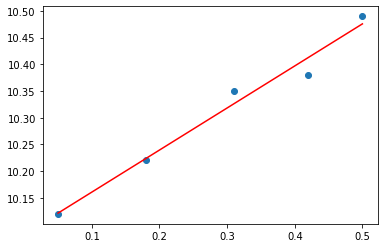

In [65]:
# linear least squares
b = inv(X.T.dot(X)).dot(X.T).dot(y)
print(b)
# predict using coefficients
yhat = X.dot(b)
# plot data and predictions
pyplot.scatter(X_1, y)
pyplot.plot(X_1, yhat, color='red')
pyplot.show()


In [23]:
.shape



(5, 2)

In [11]:
np.ones(X.shape)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [20]:
np.contact(X ,np.ones(X.shape))

AttributeError: module 'numpy' has no attribute 'contact'

array([[0.05, 1.  ],
       [0.18, 1.  ],
       [0.31, 1.  ],
       [0.42, 1.  ],
       [0.5 , 1.  ]])